<a href="https://colab.research.google.com/github/Jobmrtall/X-ray-Image-Classification-using-Transfer-Learning/blob/main/x_ray_image_detection_by_transfer_learning_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing neceeary librarires  and definfng classes thta we will be using latter in data loading or transforming , for the sake of cleasniness of our code we used OOP and setting seeds fo reproduciblity

In [ ]:
!pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

This code sets up the environment for a medical image classification task—specifically Chest X-ray classification—by importing essential libraries. It uses os and glob for file handling, random, numpy, and pandas for data manipulation and reproducibility, and matplotlib.pyplot for visualization. PIL.Image handles image loading, while torch, torchvision, and torchxrayvision provide deep learning tools, pre-trained medical models (like CheXNet), and image transformations. scikit-learn offers functions for data splitting and model evaluation, such as train_test_split and classification_report. The CFG class centralizes hyperparameters like image size, batch size, and random seed to ensure consistent model training. Warnings are suppressed to reduce clutter, and %matplotlib inline ensures plots render directly in Jupyter notebooks.

In [ ]:
# Import libraries
import os
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchxrayvision as xrv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Define configuration class
class CFG:
    EPOCHS = 50
    BATCH_SIZE = 64
    SEED = 42
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 1
    IMAGE_SIZE = (224, 224, 1)
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
random.seed(CFG.SEED)
np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(CFG.SEED)

unziping our image data from zip file uploaded on my drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Data (1).zip" -d ./data/

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/COVID19/COVID19(228).jpg  
  inflating: ./data/train/COVID19/COVID19(229).jpg  
  inflating: ./data/train/COVID19/COVID19(23).jpg  
  inflating: ./data/train/COVID19/COVID19(230).jpg  
  inflating: ./data/train/COVID19/COVID19(231).jpg  
  inflating: ./data/train/COVID19/COVID19(232).jpg  
  inflating: ./data/train/COVID19/COVID19(233).jpg  
  inflating: ./data/train/COVID19/COVID19(234).jpg  
  inflating: ./data/train/COVID19/COVID19(235).jpg  
  inflating: ./data/train/COVID19/COVID19(236).jpg  
  inflating: ./data/train/COVID19/COVID19(237).jpg  
  inflating: ./data/train/COVID19/COVID19(238).jpg  
  inflating: ./data/train/COVID19/COVID19(239).jpg  
  inflating: ./data/train/COVID19/COVID19(24).jpg  
  inflating: ./data/train/COVID19/COVID19(240).jpg  
  inflating: ./data/train/COVID19/COVID19(241).jpg  
  inflating: ./data/train/COVID19/COVID19(242).jpg  
  inflating: ./data/train/COVID19/COVID19(243).jpg

In [ ]:
# Step-2: Define Dataset Paths and Load Images
DATASET_PATH = '/content/data'
TRAIN_PATH = f'{DATASET_PATH}/train/'
TEST_PATH = f'{DATASET_PATH}/test/'

!ls "/content/data"

test  train


In [ ]:
# Dataset summary
print("DATASET SUMMARY")
print("---------------------------------------")
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')
print('---------------------------------------')

train_images = glob.glob(f'{TRAIN_PATH}/**/*.jpg')
test_images = glob.glob(f'{TEST_PATH}/**/*.jpg')
train_size = len(train_images)
test_size = len(test_images)
print(f'Total: {train_size + test_size}')

DATASET SUMMARY
---------------------------------------
there are 2 directories and 0 images in /content/data
there are 3 directories and 0 images in /content/data/train
there are 0 directories and 460 images in /content/data/train/COVID19
there are 0 directories and 3418 images in /content/data/train/PNEUMONIA
there are 0 directories and 1266 images in /content/data/train/NORMAL
there are 3 directories and 0 images in /content/data/test
there are 0 directories and 116 images in /content/data/test/COVID19
there are 0 directories and 855 images in /content/data/test/PNEUMONIA
there are 0 directories and 317 images in /content/data/test/NORMAL
---------------------------------------
Total: 6432


In [ ]:
train_images[:5]

['/content/data/train/COVID19/COVID19(417).jpg',
 '/content/data/train/COVID19/COVID19(405).jpg',
 '/content/data/train/COVID19/COVID19(109).jpg',
 '/content/data/train/COVID19/COVID19(221).jpg',
 '/content/data/train/COVID19/COVID19(50).jpg']

In [ ]:
print(os.listdir('/content/data/train/'))
print(os.listdir('/content/data/train/COVID19')[:5])

['COVID19', 'PNEUMONIA', 'NORMAL']
['COVID19(417).jpg', 'COVID19(405).jpg', 'COVID19(109).jpg', 'COVID19(221).jpg', 'COVID19(50).jpg']


constructing a dataframe by constiuting 3 columns, one with the image path of each train and test images  (in separate dataframe) the second column  for extracting images from there folder and using there folder name as their label  and  a third column for encoding the label.

In [ ]:
# Step-3: Split the Datasets and Generate the DataFrame
def generate_labels(image_paths):
    return [os.path.basename(os.path.dirname(path)) for path in image_paths]

def build_df(image_paths):
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(image_paths)
    })
    df['label_encoded'] = df['label'].map({'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2})
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

train_df = build_df(train_images)
test_df = build_df(test_images)

In [ ]:
train_df.head()

,image_path,label,label_encoded
0,/content/data/train/NORMAL/NORMAL(365).jpg,NORMAL,1
1,/content/data/train/PNEUMONIA/PNEUMONIA(2819).jpg,PNEUMONIA,2
2,/content/data/train/PNEUMONIA/PNEUMONIA(3172).jpg,PNEUMONIA,2
3,/content/data/train/NORMAL/NORMAL(848).jpg,NORMAL,1
4,/content/data/train/PNEUMONIA/PNEUMONIA(431).jpg,PNEUMONIA,2


loading the image and viewing a sample or multiple sample that we will be working with

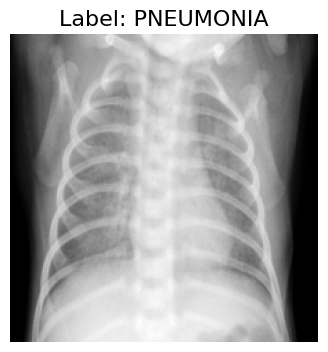

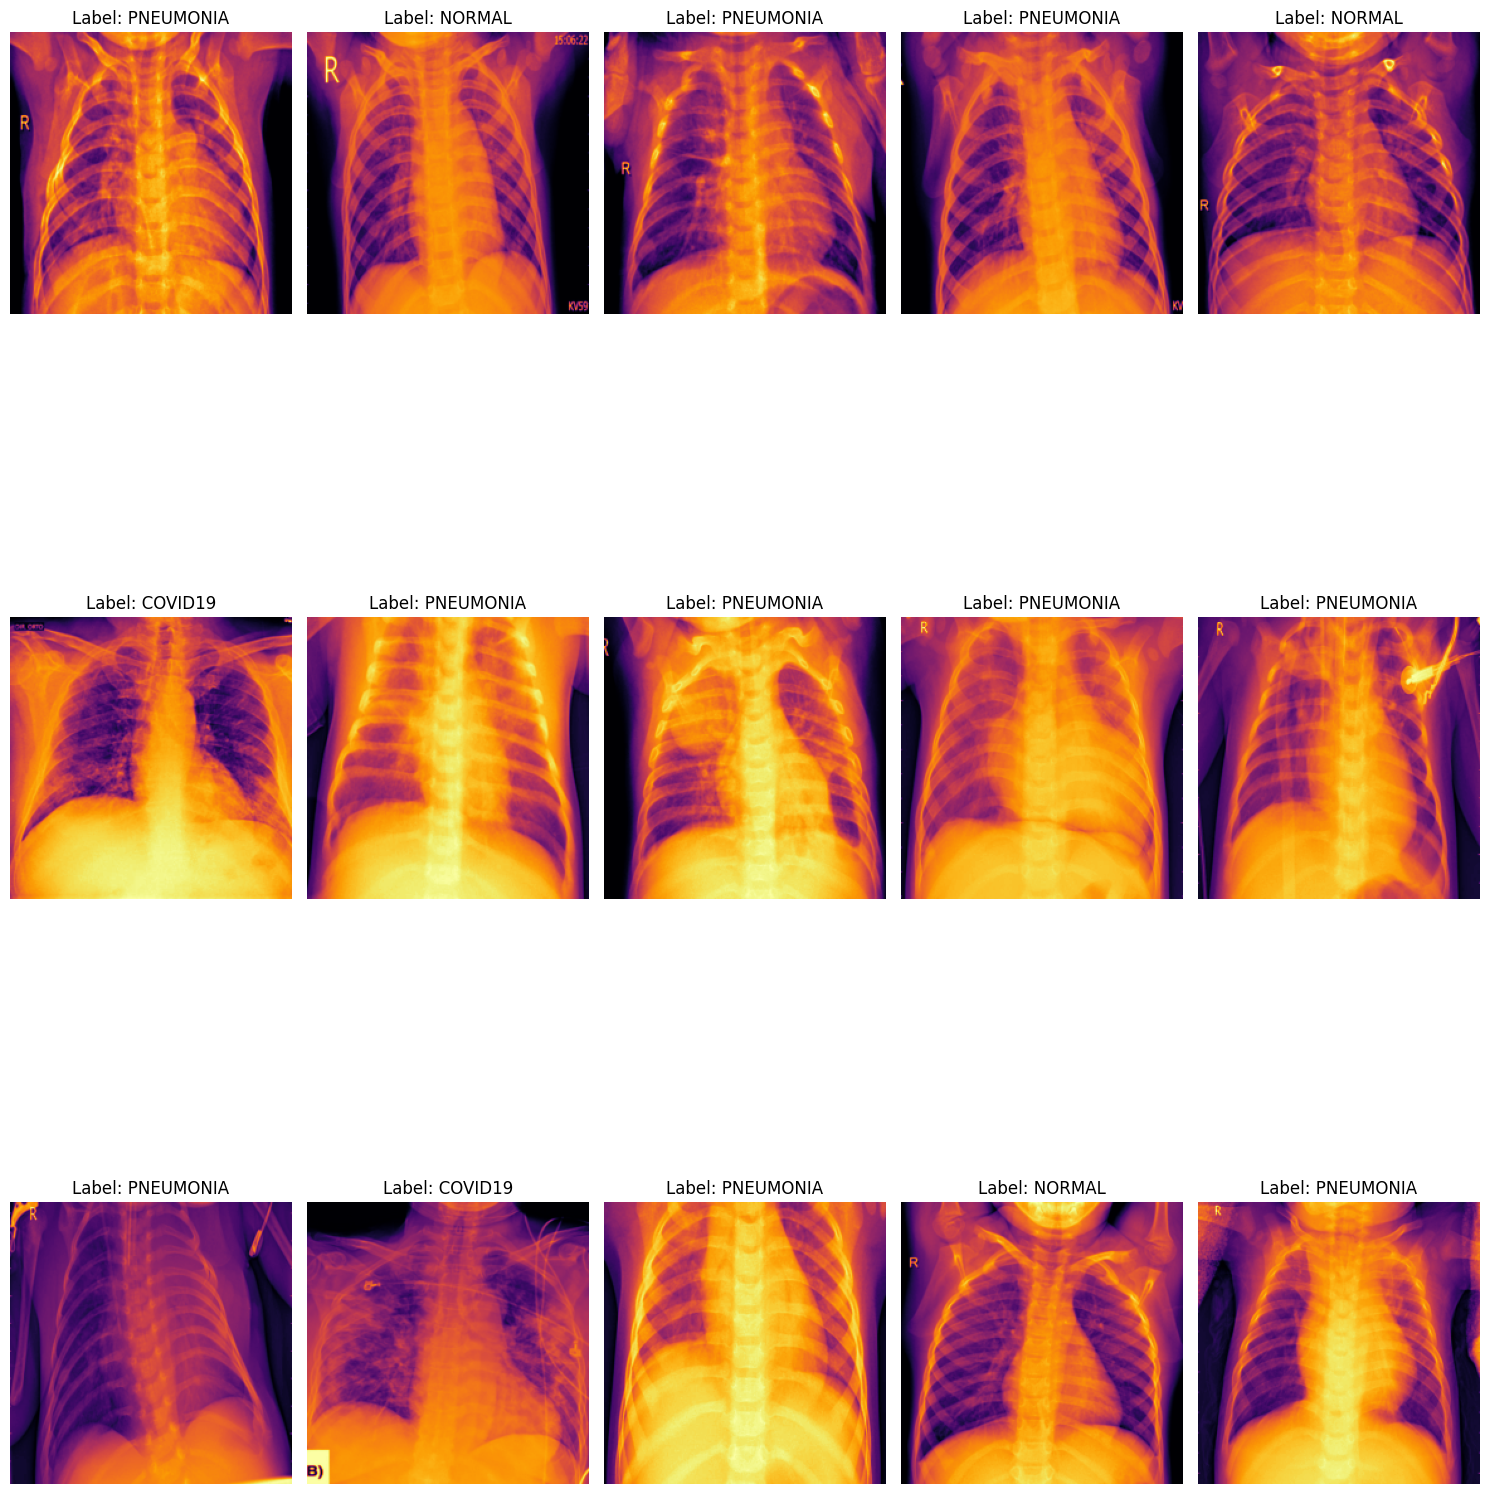

In [ ]:
# Step-4: View Multiple and Single Randomly Selected Images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Resize((CFG.HEIGHT, CFG.WIDTH))
    image = transform(image)
    return image

def view_sample(image, label, color_map='rgb', fig_size=(6, 4)):
    plt.figure(figsize=fig_size)
    if color_map == 'rgb':
        plt.imshow(image)
    else:
        plt.imshow(image.convert('L'), cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
    plt.axis('off')
    plt.show()

# View single random sample
idx = random.choice(train_df.index)
sample_image = load_image(train_df.image_path[idx])
sample_label = train_df.label[idx]
view_sample(sample_image, sample_label, color_map='gray')

# View multiple samples
def view_multiple_samples(df, count=15, color_map='rgb', fig_size=(15, 20)):
    rows = count // 5 + (1 if count % 5 > 0 else 0)
    idx = random.sample(df.index.tolist(), count)
    fig = plt.figure(figsize=fig_size)
    for i, index in enumerate(idx):
        plt.subplot(rows, 5, i + 1)
        image = load_image(df.image_path[index])
        if color_map == 'rgb':
            plt.imshow(image)
        else:
            plt.imshow(image.convert('L'), cmap=color_map)
        plt.title(f'Label: {df.label[index]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

view_multiple_samples(train_df, count=15, color_map='inferno')

splitting our train data in to 85% trainng and  15% validation by spliting it uses stratified sampling to keep the integrity of the proportion of the classes of the  images. and separating the train and validate data frame  

In [ ]:
# Step-5: Create Train/Val Split
train_split_idx, val_split_idx = train_test_split(
    train_df.index,
    test_size=0.15,
    stratify=train_df.label_encoded,
    random_state=CFG.SEED
)

train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)
print(f'Train shape: {train_new_df.shape}, Validation shape: {val_df.shape}')

Train shape: (4372, 3), Validation shape: (772, 3)


To address class imbalance—where PNEUMONIA is about 7.43 times and NORMAL about 2.75 times more frequent than COVID-19—we apply class-specific augmentations during training. Majority classes (NORMAL and PNEUMONIA) undergo moderate augmentation including resizing, horizontal flipping, slight affine transformations, and normalization, while the minority class (COVID-19) receives stronger augmentations like random rotation, color jittering, Gaussian blur, and more intense affine transforms to increase variability. Validation and testing use only resizing and normalization to ensure consistent evaluation. This tailored preprocessing pipeline replaces standard natural image transforms to better suit medical image characteristics and improve model generalization on imbalanced data.


In [ ]:
# Define transformations for 1-channel images
xrv_normalize = transforms.Lambda(lambda x: (x - 0.5) * 2048)  # To [-1024, 1024]

train_general_transform = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),  # [0,1], shape [1, H, W]
    xrv_normalize
])

train_covid_transform = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomAffine(degrees=20, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    xrv_normalize
])

val_test_transform = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.ToTensor(),
    xrv_normalize
])

We created a custom `XRayDataset` class that loads grayscale X-ray images and labels from a DataFrame, applying class-specific transformations—stronger augmentations for COVID-19 and general ones for other classes. Using this dataset, we prepare training, validation, and test sets wrapped in PyTorch DataLoaders. The training loader applies augmentations and shuffles data to enhance learning, while validation and test loaders use unaugmented, ordered images strictly for evaluation, ensuring efficient batching and streamlined model input.


In [ ]:
# Step-7: Create DataLoader for Training
# Dataset class
class XRayDataset(Dataset):
    def __init__(self, df, general_transform=None, covid_transform=None):
        self.df = df
        self.general_transform = general_transform
        self.covid_transform = covid_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.image_path.iloc[idx]
        label = self.df.label_encoded.iloc[idx]
        image = Image.open(image_path).convert('L')  # Load as grayscale

        if self.covid_transform and label == 0:  # COVID-19
            image = self.covid_transform(image)
        elif self.general_transform:
            image = self.general_transform(image)

        return image, label
  # Create datasets and loaders
train_dataset = XRayDataset(train_new_df, general_transform=train_general_transform, covid_transform=train_covid_transform)
val_dataset = XRayDataset(val_df, general_transform=val_test_transform)
test_dataset = XRayDataset(test_df, general_transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)

This code tackles class imbalance by extracting encoded training labels to compute class weights, which are then normalized via min-max scaling (not 0–1) to prevent vanishing gradients and converted to PyTorch tensors on the target device. It loads the pre-trained CheXNet (DenseNet121), adapts it for a 3-class task by replacing the classifier, and freezes all layers initially. To enable effective transfer learning, it selectively unfreezes the last dense block, normalization layer, and classifier for fine-tuning on the specific dataset, then moves the model to the designated device for training.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

labels = train_new_df.label_encoded.values
class_labels = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)
class_weights = class_weights / class_weights.min()
print(f"Class weights: {class_weights}")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(CFG.DEVICE)

# Define the model
model = xrv.models.DenseNet(weights="densenet121-res224-all")  # CheXNet pre-trained on X-rays
model.classifier = nn.Linear(model.classifier.in_features, 3)

 # Adjust for 3 classes
model = model.to(CFG.DEVICE)
model.op_threshs = None
for param in model.parameters():
    param.requires_grad = False

# Collect parameters to unfreeze
unfrozen_backbone_params = []
classifier_params = []

for name, param in model.named_parameters():
    if any(x in name for x in ["denseblock4", "norm5"]):  # "relu" removed as it’s not a parameter name
        param.requires_grad = True
        unfrozen_backbone_params.append(param)
    elif "classifier" in name:
        param.requires_grad = True
        classifier_params.append(param)

Class weights: [7.42966752 2.69981413 1.        ]
If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


The loss function is a weighted CrossEntropyLoss that uses precomputed class weights to emphasize underrepresented classes during training. The optimizer is SGD with momentum and weight decay, configured with two parameter groups: a lower learning rate (1e-4) for the unfrozen backbone layers to preserve learned features, and a higher learning rate (1e-3) for the classifier parameters to enable faster adaptation to the new 3-class task. This setup balances stable fine-tuning of pretrained layers with targeted training of the new classifier, a common and effective strategy in transfer learning.


In [ ]:

#  Define Loss Function with Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.SGD([
    {'params': unfrozen_backbone_params, 'lr': 1e-4},
    {'params': classifier_params, 'lr': 1e-3}
], momentum=0.9, weight_decay=1e-4)

This code implements a training pipeline for a deep learning model with early stopping to prevent overfitting. The `EarlyStopping` class monitors validation loss and stops training if it doesn’t improve after a set patience, saving the best model state. The `train_model` function performs epoch-wise training and validation: it trains the model on batches from the training loader, calculates loss and accuracy, then evaluates on the validation loader without gradient updates. Training and validation metrics are tracked and printed each epoch. If validation loss stagnates beyond the patience threshold, early stopping triggers and restores the best model. Finally, the trained model’s weights are saved to disk for future use.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
        return self.counter >= self.patience

# Training function
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    early_stopping = EarlyStopping(patience=5)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= train_total
        train_acc = train_correct / train_total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        if early_stopping(val_loss, model):
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

    return history

# Train the model
print(f'Training CheXNet (DenseNet121).')
print(f'Train on: {len(train_dataset)} samples, Validate on: {len(val_dataset)} samples.')
print('----------------------------------------------------------')
history = train_model(model, train_loader, val_loader, CFG.EPOCHS, criterion, optimizer)

torch.save(model.state_dict(), "chexnet_xray_model.pth")

Training CheXNet (DenseNet121).
Train on: 4372 samples, Validate on: 772 samples.
----------------------------------------------------------
Epoch [1/50], Train Loss: 1.0125, Val Loss: 0.9172, Train Acc: 0.3683, Val Acc: 0.5881
Epoch [2/50], Train Loss: 0.8409, Val Loss: 0.8127, Train Acc: 0.7292, Val Acc: 0.6995
Epoch [3/50], Train Loss: 0.7373, Val Loss: 0.7446, Train Acc: 0.7994, Val Acc: 0.7358
Epoch [4/50], Train Loss: 0.6707, Val Loss: 0.7073, Train Acc: 0.8113, Val Acc: 0.7435
Epoch [5/50], Train Loss: 0.6322, Val Loss: 0.6727, Train Acc: 0.8138, Val Acc: 0.7707
Epoch [6/50], Train Loss: 0.5933, Val Loss: 0.6489, Train Acc: 0.8301, Val Acc: 0.7772
Epoch [7/50], Train Loss: 0.5579, Val Loss: 0.6230, Train Acc: 0.8323, Val Acc: 0.7772
Epoch [8/50], Train Loss: 0.5362, Val Loss: 0.6098, Train Acc: 0.8394, Val Acc: 0.7772
Epoch [9/50], Train Loss: 0.5147, Val Loss: 0.5994, Train Acc: 0.8417, Val Acc: 0.7915
Epoch [10/50], Train Loss: 0.5121, Val Loss: 0.5872, Train Acc: 0.8429, Val 

This code evaluates the trained model on the test dataset. It sets the model to evaluation mode to disable dropout and gradient computation, then iterates over the test data loader to generate predictions without updating model weights. Predicted and true labels are collected and moved to the CPU for analysis. Finally, it prints a detailed classification report showing precision, recall, and F1-score for each class (COVID-19, NORMAL, PNEUMONIA), providing a comprehensive assessment of the model’s performance on unseen data.


In [ ]:
# Evaluate on test set
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print(classification_report(test_labels, test_predictions, target_names=['COVID-19', 'NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

    COVID-19       0.65      0.80      0.72       116
      NORMAL       0.79      0.94      0.86       317
   PNEUMONIA       0.96      0.87      0.91       855

    accuracy                           0.88      1288
   macro avg       0.80      0.87      0.83      1288
weighted avg       0.89      0.88      0.88      1288



This code defines and calls a function to visualize the model’s training progress by plotting loss and accuracy curves over epochs. It creates side-by-side line plots showing training and validation loss on one axis (where lower values indicate better performance) and training and validation accuracy on the other (where higher values are better). Markers highlight each epoch’s value, and legends clarify which line corresponds to which metric. These plots help diagnose model behavior, such as overfitting or underfitting, by comparing training and validation trends visually.


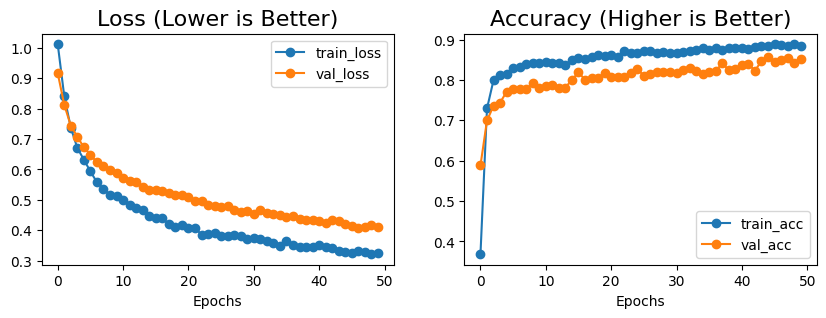

In [ ]:
# Step-10: Plot Training Curves
def plot_training_curves(history):
    epochs = range(len(history['train_loss']))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    ax1.plot(epochs, history['train_loss'], label='train_loss', marker='o')
    ax1.plot(epochs, history['val_loss'], label='val_loss', marker='o')
    ax1.set_title('Loss (Lower is Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend()

    ax2.plot(epochs, history['train_acc'], label='train_acc', marker='o')
    ax2.plot(epochs, history['val_acc'], label='val_acc', marker='o')
    ax2.set_title('Accuracy (Higher is Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend()

    plt.show()

plot_training_curves(history)

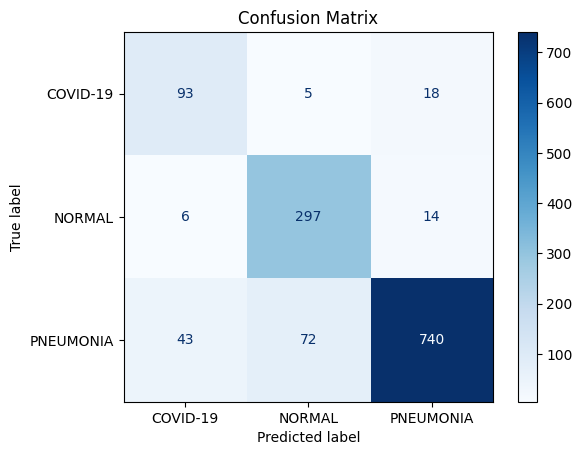

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Display it with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID-19', 'NORMAL', 'PNEUMONIA'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
test_predictions, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


In [ ]:
import pandas as pd

# Define class names in order
class_names = ['COVID-19', 'NORMAL', 'PNEUMONIA']

# Create DataFrame with actual and predicted class names
results_df = pd.DataFrame({
    'True Label': [class_names[label] for label in test_labels],
    'Predicted Label': [class_names[pred] for pred in test_predictions]
})

# Show first 10 results
print(results_df.head(10))


  True Label Predicted Label
0     NORMAL          NORMAL
1     NORMAL          NORMAL
2  PNEUMONIA       PNEUMONIA
3   COVID-19        COVID-19
4   COVID-19        COVID-19
5  PNEUMONIA       PNEUMONIA
6  PNEUMONIA       PNEUMONIA
7     NORMAL          NORMAL
8  PNEUMONIA       PNEUMONIA
9   COVID-19        COVID-19


In [ ]:
results_df.to_csv("test_predictions.csv", index=False)
print("Raw test results saved to test_predictions.csv")


Raw test results saved to test_predictions.csv


In [ ]:
from sklearn.metrics import roc_auc_score

# y_val: true labels from validation/test set
# y_proba: predicted probabilities (not class labels!) from model

# If using CatBoost:
y_proba = model.predict_proba(X_val)[:, 1]  # Get probabilities for positive class
auc = roc_auc_score(y_val, y_proba)

print(f"AUC: {auc:.4f}")
